In [20]:
import os
import struct
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

In [21]:
class NearestNeighborClassifier(object):
    """A generic k-nearest neighbor predictor.

    You need to extend this class and implement distance(from, to)
    and consensus(label_list) in order to make this functional."""
    
    def __init__(self, dataset, k):
        """Create a new nearest neighbor classifier.

        dataset - a list of data points. Each data point is an (x, y) pair,
                  where x is the input and y is the label.
        k - the number of neighbors to search for."""
        # Note how we don't have to do any initialization!
        # Once we have a dataset, we can immediately get predictions on new values.
        self.dataset = dataset
        self.k = k
        
    def predict(self, point):
        """Return the k-nearest neighbor prediction for a point."""
        # Compute distances to every point in the data set.
        distances = [self.distance(x[0], point) for x in self.dataset]
        
        # Naive approach: sort based on distances, take the first k elements.
        values = zip(distances, self.dataset)
        values.sort(key = lambda val: val[0])
        
        # Predict by averaging the closets k elements.
        prediction = self.consensus([value[1][1] for value in values[0:k]])
        return prediction

In [22]:
def predict(self, point):
    # We have to copy the data set list, because once we've located the best
    # candidate from it, we don't want to see that candidate again, so we'll delete it.
    candidates = self.dataset[:]
    
    # Loop until we've gotten all the neighbors we want.
    neighbors = []
    while len(neighbors) < self.k:
        # Compute distances to every candidate.
        distances = [self.distance(x[0], point) for x in candidates]
        
        # Find the minimum distance neighbor.
        best_distance = min(distances)
        index = distances.index(best_distance)
        neighbors.append(candidates[index])
        
        # Remove the neighbor from the candidates list.
        del candidates[index]
    
    # Predict by averaging the closets k elements.
    prediction = self.consensus([value[1] for value in neighbors])
    return prediction
        
# Let's go ahead and replace the old implementation.
NearestNeighborClassifier.predict = predict

In [23]:
import subprocess

def download(url):
    """Download a GZIP archive, return the data as a byte string."""
    # Do the download by shelling out to curl.
    cmd = 'curl "%s" | gzip -d' % url
    return subprocess.check_output(cmd, shell=True)

def get_files():
    """Download MNIST files from the internet."""
    url_format = "http://yann.lecun.com/exdb/mnist/%s-%s-idx%d-ubyte.gz"
    files = [("train", "images", 3), ("train", "labels", 1),
             ("t10k", "images", 3), ("t10k", "labels", 1)]
    
    urls = [url_format % values for values in files]
    data = [download(url) for url in urls]
    return data

data = get_files()

In [24]:
import struct
from numpy import *

def parse_labels(data):
    """Parse labels from the binary file."""
    
    # We're going to use the Python 'struct' package. 
    # This is an incredibly nice package which allows us to specify the format
    # our data is in, and then automatically parses the data from the string.
    # Let's start by getting the magic number and the length: the first character
    # represents the endianness of the data (in our case, '>' for big endian), while
    # the next characters are the format string ('2i' for two integers).
    magic, n = struct.unpack_from('>2i', data)
    assert magic == 2049, "Wrong magic number: %d" % magic
    
    # Next, let's extract the labels.
    labels = struct.unpack_from('>%dB' % n, data, offset=8)
    return labels
    
def parse_images(data):
    """Parse images from the binary file."""
    
    # Parse metadata.
    magic, n, rows, cols = struct.unpack_from('>4i', data)
    assert magic == 2051, "Wrong magic number: %d" % magic
    
    # Get all the pixel intensity values.
    num_pixels = n * rows * cols
    pixels = struct.unpack_from('>%dB' % num_pixels, data, offset=16)
    
    # Convert this data to a NumPy array for ease of use.
    pixels = asarray(pixels, dtype=ubyte)
    
    # Reshape into actual images instead of a 1-D array of pixels.
    images = pixels.reshape((n, cols, rows))
    return images

train_images = parse_images(data[0])
train_labels = parse_labels(data[1])
test_images = parse_images(data[2])
test_labels = parse_labels(data[3])

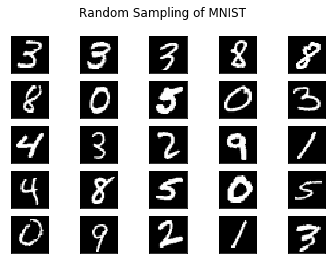

In [25]:
from matplotlib.pyplot import *

# Get the figure and axes.
fig, axes = subplots(5, 5)
axes = axes.reshape(25)
fig.suptitle("Random Sampling of MNIST")

# Plot random images.
indices = random.randint(len(train_images), size=25)
for axis, index in zip(axes, indices):
    image = train_images[index, :, :]
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    axis.imshow(image, cmap = cm.Greys_r)

In [12]:
def euclidean_distance(img1, img2):
    # Since we're using NumPy arrays, all our operations are automatically vectorized.
    # A breakdown of this expression:
    #     img1 - img2 is the pixel-wise difference between the images
    #     (img1 - img2) ** 2 is the same thing, with each value squared
    #     sum((img1 - img2) ** 2) is the sum of the elements in the matrix.
    return sum((img1 - img2) ** 2)

In [13]:
from collections import defaultdict
def get_majority(votes):
    # For convenience, we're going to use a defaultdict.
    # This is just a dictionary where values are initialized to zero
    # if they don't exist.
    counter = defaultdict(int)
    for vote in votes:
        # If this weren't a defaultdict, this would error on new vote values.
        counter[vote] += 1
    
    # Find out who was the majority.
    majority_count = max(counter.values())
    for key, value in counter.items():
        if value == majority_count:
            return key

In [15]:
# Create the predictor class.
class MNISTPredictor(NearestNeighborClassifier):
    def distance(self, p1, p2):
        return euclidean_distance(p1, p2)
    
    def consensus(self, values):
        return get_majority(values)
    
# Convert our data set into an easy format to use.
# This is a list of (x, y) pairs. x is an image, y is a label.
dataset = []
for i in range(len(train_images)):
    dataset.append((train_images[i, :, :], train_labels[i]))
    
# Create a predictor for various values of k.
ks = [1, 2, 3, 4, 5, 6]
predictors = [MNISTPredictor(dataset, k) for k in ks] 

In [17]:
def predict_test_set(predictor, test_set):
    """Compute the prediction for every element of the test set."""
    predictions = [predictor.predict(test_set[i, :, :]) 
                   for i in range(len(test_set))]
    return predictions

# Choose a subset of the test set. Otherwise this will never finish.
test_set = test_images[0:100, :, :]
all_predictions = [predict_test_set(predictor, test_set) for predictor in predictors]

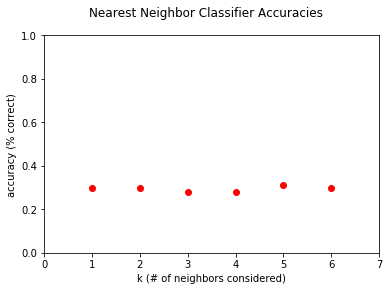

In [26]:
import matplotlib.pyplot as plt

def evaluate_prediction(predictions, answers):
    """Compute how many were identical in the answers and predictions,
    and divide this by the number of predictions to get a percentage."""
    correct = sum(asarray(predictions) == asarray(answers))
    total = float(prod(answers.shape))
    return correct / total

labels = asarray(test_labels[0:100])
accuracies = [evaluate_prediction(pred, labels) for pred in all_predictions]

# Draw the figure.
fig = figure(1)
plt.plot(ks, accuracies, 'ro', figure=fig)

fig.suptitle("Nearest Neighbor Classifier Accuracies")
fig.axes[0].set_xlabel("k (# of neighbors considered)")
fig.axes[0].set_ylabel("accuracy (% correct)");
fig.axes[0].axis([0, max(ks) + 1, 0, 1]);